# Hidden Markov Models
## Case Study:  The GBPEUR Exchange rate overe the last five years

<br>
The data will be downloaded using a spreadsheet (<i>googlefinance client no longer works)  </i><br>
Note that the hmm is no longer part of sklearn (release 0.17). The command <i>pip install hmmlearn</i> is required.

### 1. Import the necessary packages

In [2]:
# Import the necessary packages
import warnings
import numpy as np
# Import hmmlearn: A simple set of algorithms and models to learn HMMs (Hidden Markov Models) in Python
from hmmlearn import hmm


import pandas as pd

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline


# add a warning suppressing
# warnings.filterwarnings("ignore")

### 2. Retrieve the data

In [3]:
# use pandas to read the CSV file
df = pd.read_excel('EURGBP.xlsx',index_col='date')
df.head()

,EURGBP
date,
2007-10-23,0.69575
2007-10-24,0.69550
2007-10-25,0.69765
2007-10-26,0.70100
2007-10-29,0.69895


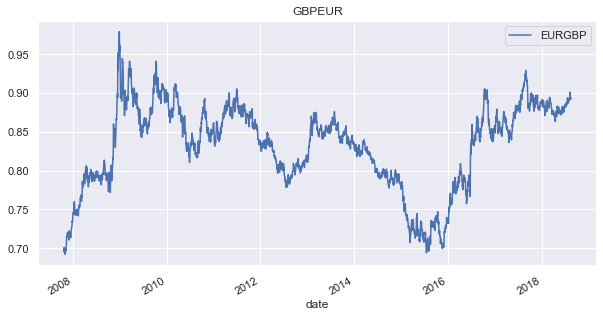

In [4]:
# Plot the values in the dataframe
df.plot(figsize=(10,5),title='GBPEUR');

### 3. Calculating (log) returns for the dataset

In [5]:
# Use pandas' percentage change method with one period
df['Ret']= df['EURGBP'].pct_change(periods=1)
# use apply and a lamda function to get the log value of each entry
df['LogRet'] = df['Ret'].apply(lambda x: np.log(1+x))
# Delete al the columns with a Nan (Not a number) value
df.dropna(how='any',inplace=True)

### 4. Defining and training the model

We opt for a hidden markov model with <b>3 hidden states </b>. Each state has a <b> Gaussian Emission </b> to visible states. The visible states are the sequence of daily logreturns observed for the GBPEUR Exchange Rate.

In [6]:
# Reshape the data
X = df['LogRet'].values.reshape(-1,1)
# Initialize a Gaussian HMM with 3 components
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
# Fit the model to the data
model.fit(X)

GaussianHMM(covariance_type='full', n_components=3)

Fitting the model to the data will reveal information on :
<ol>
<li> The transition matrix "orchestrating" the way that the hidden states move between each other. 
<li> The Emission from each of the hidden states to the visible states takes Gaussian model (mean + variance)
</ol>

In [7]:
print('transition matrix')
# convert the transition matrix into a data frame
pd.DataFrame(model.transmat_)

transition matrix


,0,1,2
0,0.248333,0.370863,0.380804
1,0.192419,0.398190,0.409391
2,0.192275,0.398235,0.409491


In [8]:
print('Means of the Gaussians')
print(model.means_.ravel())
print('Hidden State 0 is producing random normal numbers with mean ',np.round(np.float(model.means_[0]),8))

Means of the Gaussians
[ 5.36771149e-04 -3.19254103e-05 -1.92063524e-05]
Hidden State 0 is producing random normal numbers with mean  0.00053677


In [9]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100)

Standard deviations
[0.94640303 0.56854351 0.56315917]


### 5. Improve the model

The first two states generate returns with a very similar standard deviation and it makes sense to group these together.
Both hidden states have also positive returns. <br>
<b>=>Opting for 2 hidden states</b>

In [10]:
# Try a Gaussian HMM with 2 components this time
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
# Fit to the data
model.fit(X)

GaussianHMM(covariance_type='full', n_components=2)

In [12]:
print('transition matrix')
print(pd.DataFrame(model.transmat_))
print('\nWhat do these data tell you ?\nWhat is the most frequent state?')

transition matrix
          0         1
0  0.407078  0.592922
1  0.361882  0.638118

What do these data tell you ?
What is the most frequent state?


In [13]:
print('Means of the Gaussians')
print(model.means_.ravel())

Means of the Gaussians
[ 2.75646528e-04 -2.47910637e-05]


In [14]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100)

Standard deviations
[0.80107319 0.5057136 ]


From the sequence $X$ (= observed log returns), one can derive the corresponding hidden states. This done using the <b>Viterbi</b> algortihm

In [15]:
# use the ".predict" method to generate predictions on X
Z = model.predict(X).reshape(-1,1)

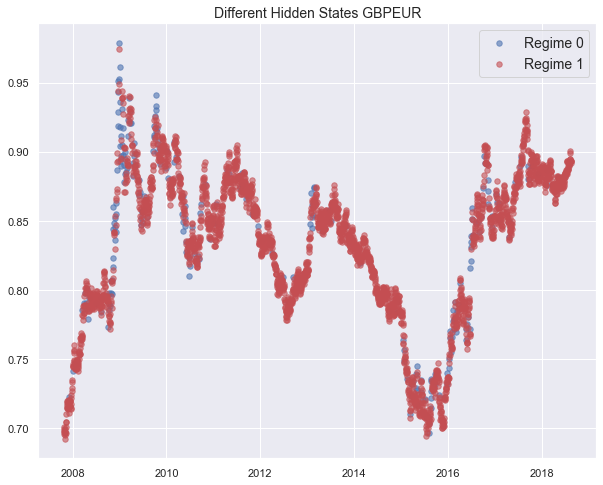

In [17]:
fig = plt.subplots(1,1,figsize=(10,8))
color = ['b','r']
size = [30,30]
for z , c , s , i in zip(np.unique(Z),
                         color,size,
                         np.arange(0,len(model.means_))):
    # Plot each hidden states and regimes
    plt.scatter(df[Z==z].index,
                df[Z==z]['EURGBP'],
                c=c,
                s=s,
                alpha=0.6,
               label='Regime '+str(i))
plt.title('Different Hidden States GBPEUR',fontsize=14);
plt.legend(loc=1,fontsize=14);

Can we plot the evolution of the "High Volatility Regime" post / pre Brexit ?
<br>In a rolling window of 250 days, we can count the number of high volatility days<br>

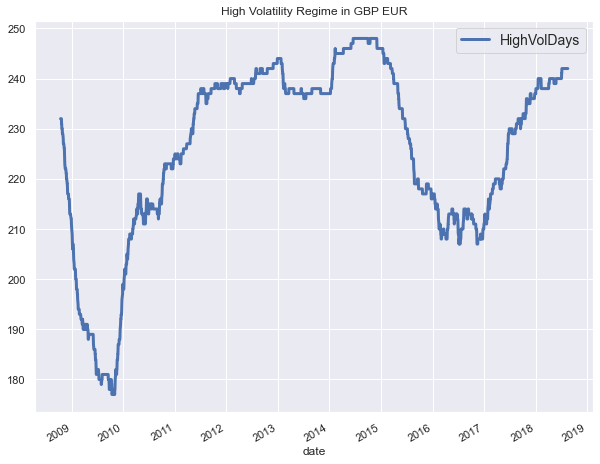

In [18]:
df['Regime']= Z
# Use a rolling windo of 250 days and ".apply" to compute the count of values = 1
df['HighVolDays']=df['Regime'].rolling(window=250).apply(lambda x : np.sum(x==1))
# Plot the results
df['HighVolDays'].plot(figsize=(10,8),title='High Volatility Regime in GBP EUR',linewidth=3);
plt.legend(fontsize=14);